In [ ]:
#Importação
#!pip install -U pandas-profiling
#!pip install pyspellchecker
#!pip install spellchecker
#!pip install spellcheck
#!pip install swifter==1.3.4 --user
#!pip install --upgrade --user pandas "dask[complete]"

# To-Do:

- Comentar e refatorar código (Daniel)
- Inserir analise da base textual (Eduardo)
- Tratamento de texto voltado a negócio (Leonardo/Daniel)
- Treinar modelo Catboost Classifier (Herikc)
- Treinar modelo XGBoost (Leonardo)
- Treinar modelo de rede neural profunda (Sugestão: CNN) (Eduardo)
- Treinar modelo baseado em ngramas (sugestão: nayve bayes) (Herikc)
- Criar um site simples (sugestão: streamlit) (Angelo)
- Criar uma api para o site consumir (Angelo)

In [2]:
#%tensorflow_version 2.x
import tensorflow as tf
import numpy as np
import pandas as pd
#from pandas_profiling import ProfileReport
import seaborn as sns
import matplotlib.pyplot as plt
import re
import string
import nltk
import unicodedata
import plotly.express as px
import plotly.graph_objects as go
import time
import swifter
import pickle

from nltk import ngrams
from nltk.corpus import stopwords
from sklearn import preprocessing
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
from nltk.tokenize import word_tokenize, RegexpTokenizer
from itertools import chain
from spellchecker import SpellChecker
from nltk import bigrams
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import RidgeClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn import metrics
from sklearn.metrics import accuracy_score
from swifter import set_defaults
from sklearn.metrics import confusion_matrix
from catboost import CatBoostClassifier
from catboost import Pool, cv

tf.__version__

C:\Users\herik\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\herik\anaconda3\lib\site-packages\numpy\.libs\libopenblas.4SP5SUA7CBGXUEOC35YP2ASOICYYEQZZ.gfortran-win_amd64.dll
C:\Users\herik\anaconda3\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


'2.10.0'

In [3]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\herik\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\herik\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\herik\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [4]:
# Configurando swifter 
set_defaults(
    npartitions = None,
    dask_threshold = 1,
    scheduler = "processes",
    progress_bar = True,
    progress_bar_desc = None,
    allow_dask_on_strings = True,
    force_parallel = True,
)

In [5]:
# Em desenvolvimento
dev = True

In [6]:
#Importação base de dados
df = pd.read_csv(r'data\produtos_pre_tratamento.csv')
df.shape #Quantidade de linha e colunas do data frame

(9840, 2)

In [7]:
df.head()

descricao  categoria
0               CANETA BIC CRISTAL AZUL  Papelaria
1   CANETA BIC CRISTAL AZUL (FILIAL 12)  Papelaria
2              CANETA BIC CRISTAL PRETA  Papelaria
3  CANETA BIC CRISTAL PRETA (FILIAL 12)  Papelaria
4           CANETA BIC CRISTAL VERMELHA  Papelaria

In [8]:
df = df.rename({'categoria': 'Categoria'}, axis = 1)

In [9]:
#df['Categoria'] = df['Nova cat 1'] + ' - ' + df['Nova cat 2'] + ' - ' + df['Nova cat 3']

In [10]:
df = df[['descricao', 'Categoria']]

In [11]:
df.dtypes

descricao    object
Categoria    object
dtype: object

In [12]:
df = df[df['Categoria'] != 'Não Classificado - Não Classificado - Não Classificado']

In [13]:
df.shape

(9840, 2)

In [14]:
df.head()

descricao  Categoria
0               CANETA BIC CRISTAL AZUL  Papelaria
1   CANETA BIC CRISTAL AZUL (FILIAL 12)  Papelaria
2              CANETA BIC CRISTAL PRETA  Papelaria
3  CANETA BIC CRISTAL PRETA (FILIAL 12)  Papelaria
4           CANETA BIC CRISTAL VERMELHA  Papelaria

In [15]:
dfManipulated = df.copy()

In [16]:
# pyspellchecker
spell = SpellChecker(language='pt')

def pyspellchecker(text):
    word_list = word_tokenize(text, language = 'portuguese')
    word_list_corrected = []
    for word in word_list:
        if word in spell.unknown(word_list) and len(word) > 3:
            word_corrected = spell.correction(word)
            if word_corrected == None:
                word_list_corrected.append(word)
            else:
                word_list_corrected.append(word_corrected)
        else:
            word_list_corrected.append(word)
    text_corrected = " ".join(word_list_corrected)
    return text_corrected

In [17]:
def strip_accents(s):
   return ''.join(c for c in unicodedata.normalize('NFD', s)
                  if unicodedata.category(c) != 'Mn')

In [18]:
def limpar_texto(text):
    # Convertendo para str
    text = str(text)

    # Remover caracteres non-ascii
    text = ''.join(caracter for caracter in text if ord(caracter) < 128)

    # Convertendo para lower case
    text = text.lower()

    # Removendo pontuação por expressão regular
    regex = re.compile('[' + re.escape(string.punctuation) + '\\r\\t\\n]')
    text = regex.sub(' ', str(text))

    text = re.sub('[^A-Za-z ]+', '', text)

    # Carregando stopwords em português
    portuguese_stops = set(stopwords.words('portuguese'))

    # Removendo stopwords em português
    # Mantendo somente palavras que não são consideradas stopwords
    text = ' '.join(palavra for palavra in text.split() if palavra not in portuguese_stops)

    # Remover palavras com menos de 2 caracteres
    words = text.split()
    text = [word for word in words if len(word) > 2 or word == ' ']
    text = ' '.join(text)

    # Corrigindo erros gramaticais
    text = pyspellchecker(text)

    # Criando a estrutura baseada em uma wordnet para lemmatization
    wordnet_lemmatizer = WordNetLemmatizer()
    # Aplicando Lemmatization
    text = ' '.join(wordnet_lemmatizer.lemmatize(palavra) for palavra in text.split())

    # Remover palavras com menos de 2 caracteres residuais
    words = text.split()
    text = [word for word in words if len(word) > 2 or word == ' ']
    text = ' '.join(text)

    text = strip_accents(text)

    return text

In [19]:
%%time

if not dev:
    print('Tratanto texto...')
    dfManipulated['descricao'] = dfManipulated['descricao'].swifter.apply(limpar_texto)
    print('Texto tratado')
    pd.to_csv(r'data\produtos_pos_tratamento.csv', index = False)
else:
    dfManipulated = pd.read_csv(r'data\produtos_pos_tratamento.csv')
    dfManipulated = dfManipulated[['descricao', 'Categoria']]
    
    with open('models\label_encoder.pkl', 'rb') as file:
        le = pickle.load(file)
    
    le.inverse_transform(dfManipulated['Categoria'])

CPU times: total: 15.6 ms
Wall time: 11 ms


C:\Users\herik\anaconda3\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator LabelEncoder from version 1.2.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [20]:
dfManipulated['Categoria'] = dfManipulated['Categoria'].replace(0, 'Embalagem')
dfManipulated['Categoria'] = dfManipulated['Categoria'].replace(1, 'Epi')
dfManipulated['Categoria'] = dfManipulated['Categoria'].replace(2, 'Papelaria')
dfManipulated['Categoria'] = dfManipulated['Categoria'].replace(3, 'Hidráulico')

C:\Users\herik\AppData\Local\Temp\ipykernel_31532\2355854640.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfManipulated['Categoria'] = dfManipulated['Categoria'].replace(0, 'Embalagem')
C:\Users\herik\AppData\Local\Temp\ipykernel_31532\2355854640.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfManipulated['Categoria'] = dfManipulated['Categoria'].replace(1, 'Epi')
C:\Users\herik\AppData\Local\Temp\ipykernel_31532\2355854640.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of

In [21]:
df.iloc[4][0]

'CANETA BIC CRISTAL VERMELHA'

In [22]:
dfManipulated.iloc[4][0]

'caneta bic cristal vermelha'

In [23]:
# Verificando dimensionalidade
print(dfManipulated.shape)

# Existe NAs
print(dfManipulated.isna().sum())

# Existe duplicados
print(dfManipulated.duplicated().sum())

# Removendo duplicados
dfManipulated.drop_duplicates(inplace=True)

# Verificando dimensionalidade final
print(dfManipulated.shape)

(5862, 2)
descricao    0
Categoria    0
dtype: int64
30
(5832, 2)


C:\Users\herik\AppData\Local\Temp\ipykernel_31532\2374328630.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfManipulated.drop_duplicates(inplace=True)


In [24]:
print("Distribuição das classes \n\n", dfManipulated.Categoria.value_counts())

Distribuição das classes 

 Categoria
Embalagem     1948
Hidráulico    1822
Epi           1333
Papelaria      729
Name: count, dtype: int64


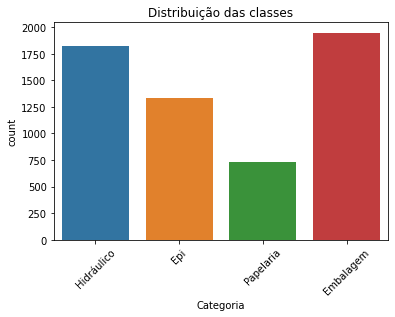

In [25]:
sns.countplot(data=dfManipulated, x="Categoria")
plt.title("Distribuição das classes")
plt.xticks(rotation=45)
plt.show()

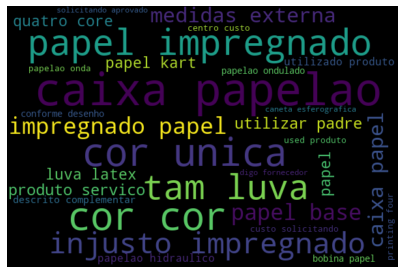

In [26]:
wordcloud = WordCloud(width = 600, height = 400, max_words=30).generate_from_text(\
                                                                ' '.join(dfManipulated['descricao']))
plt.figure(figsize = (7, 7))
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.show()

In [27]:
unique_values = dfManipulated['Categoria'].unique()

print("Unique values in", 'Categoria', "column:", unique_values, sep='\n')

Unique values in
Categoria
column:
['Hidráulico' 'Epi' 'Papelaria' 'Embalagem']


In [28]:
def generate_wordcloud(categoria):
  global dfManipulated

  dfTemp = dfManipulated.loc[dfManipulated['Categoria'] == categoria]

  wordcloud = WordCloud(width = 600, height = 400, max_words=30).generate_from_text(' '.join(dfTemp['descricao']))
  plt.figure(figsize = (7, 7))
  plt.title(categoria)
  plt.imshow(wordcloud, interpolation = 'bilinear')
  plt.axis('off')
  plt.show()

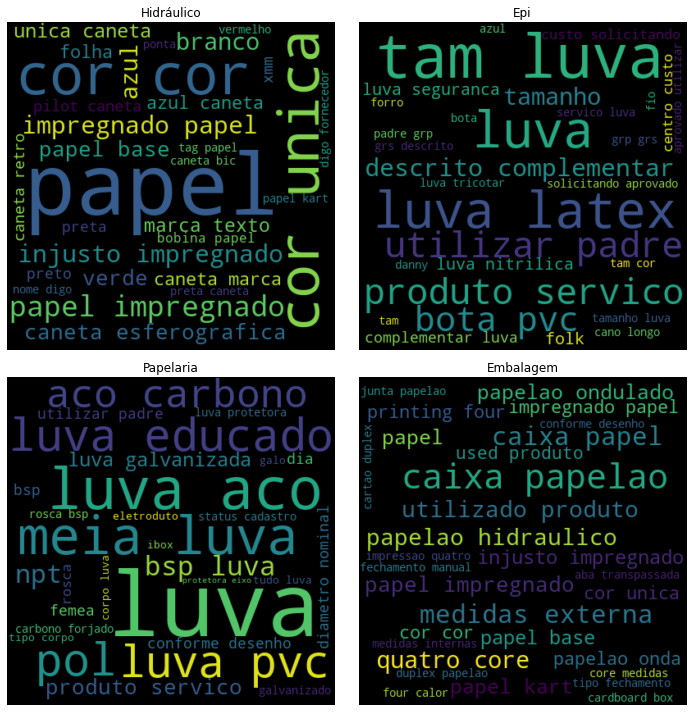

In [29]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

for idx in range(len(unique_values)):
    # Calcula a respectiva linha e coluna do plot
    row = idx // 2
    col = idx % 2

    category = unique_values[idx]

    # Constroi a lista de palavras da wordcloud
    dfTemp = dfManipulated[dfManipulated['Categoria'] == category].copy()

    # Alimenta a wordcloud e joga no subplot
    wordcloud = WordCloud(width=400, height=400, max_words=30).generate_from_text(' '.join(dfTemp['descricao']))
    axs[row, col].imshow(wordcloud, interpolation='bilinear')
    axs[row, col].axis('off')
    axs[row, col].set_title(category)

plt.tight_layout()
plt.show()

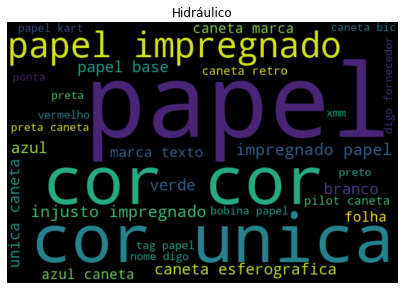

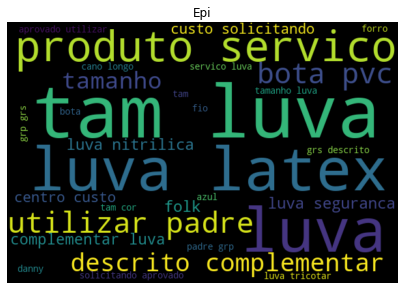

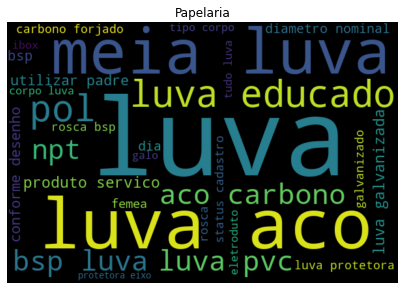

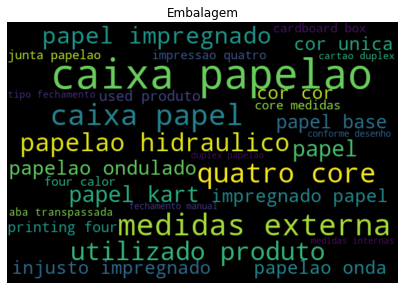

[None, None, None, None]

In [30]:
[generate_wordcloud(item) for item in unique_values]

In [31]:
from nltk.tokenize import word_tokenize

In [32]:
def descrica_ngrams(df, n_grams = 2):
  tokens = [word_tokenize(desc) for desc in df['descricao']]

  ngram_list = []
  for tokens in tokens:
    ngram_for_desc = list(ngrams(tokens, n_grams))
    ngram_list.extend(ngram_for_desc)

  n_gram_freq = nltk.FreqDist(ngram_list)

  # Convert bigrams back to strings
  n_gram_strings = [' '.join(ngram) for ngram in n_gram_freq]

  # Get the top N most common bigrams and their frequencies
  top_n = 10
  top_ngrams = n_gram_freq.most_common(top_n)

  # Extract bigram labels and frequencies for the bar chart
  ngram_labels = [' '.join(ngram) for ngram, freq in top_ngrams]
  ngram_frequencies = [freq for ngram, freq in top_ngrams]

  return ngram_labels, ngram_frequencies

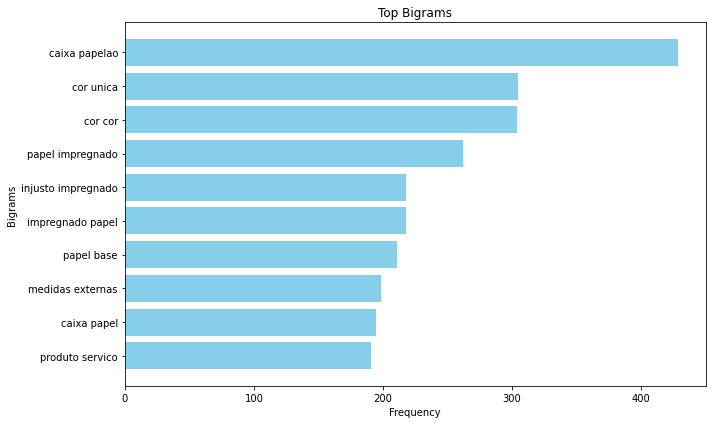

In [33]:
# Create a horizontal bar chart
bigram_labels, bigram_frequencies = descrica_ngrams(dfManipulated, 2)
plt.figure(figsize=(10, 6))
plt.barh(bigram_labels, bigram_frequencies, color='skyblue')
plt.xlabel('Frequency')
plt.ylabel('Bigrams')
plt.title('Top Bigrams')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest frequency at the top
plt.tight_layout()
plt.show()

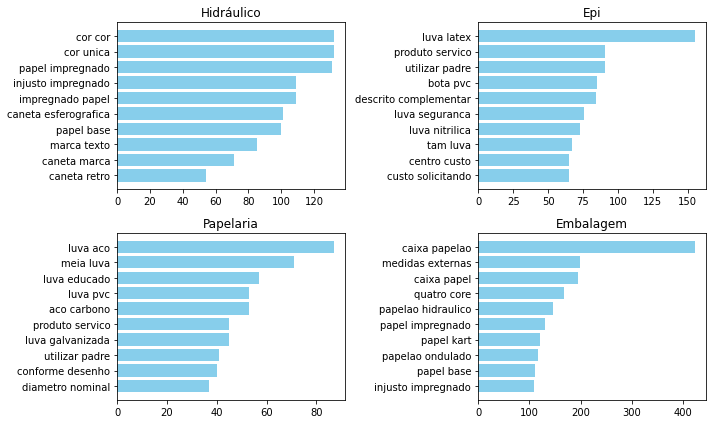

In [34]:
fig, axs = plt.subplots(2, 2, figsize=(10, 6))

for idx in range(len(unique_values)):
    # Calcula a respectiva linha e coluna do plot
    row = idx // 2
    col = idx % 2

    category = unique_values[idx]

    # Constroi a lista de palavras da wordcloud
    dfTemp = dfManipulated[dfManipulated['Categoria'] == category].copy()

    bigram_labels, bigram_frequencies = descrica_ngrams(dfTemp, 2)

    # Create a horizontal bar chart
    axs[row, col].barh(bigram_labels, bigram_frequencies, color='skyblue')
    axs[row, col].set_title(category)
    axs[row, col].invert_yaxis()

plt.tight_layout()
plt.show()

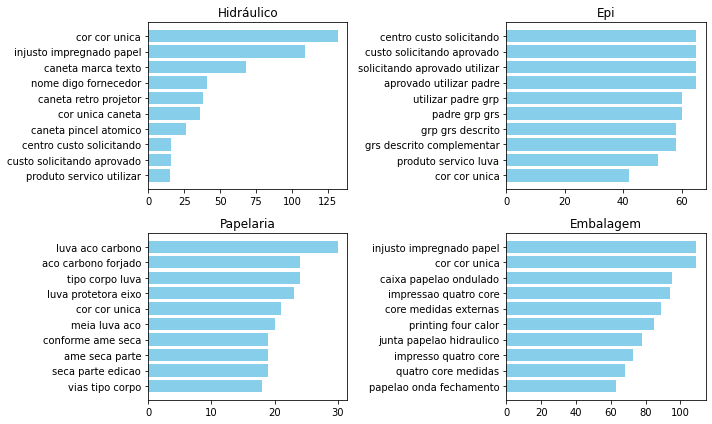

In [35]:
fig, axs = plt.subplots(2, 2, figsize=(10, 6))

for idx in range(len(unique_values)):
    # Calcula a respectiva linha e coluna do plot
    row = idx // 2
    col = idx % 2

    category = unique_values[idx]

    # Constroi a lista de palavras da wordcloud
    dfTemp = dfManipulated[dfManipulated['Categoria'] == category].copy()

    bigram_labels, bigram_frequencies = descrica_ngrams(dfTemp, 3)

    # Create a horizontal bar chart
    axs[row, col].barh(bigram_labels, bigram_frequencies, color='skyblue')
    axs[row, col].set_title(category)
    axs[row, col].invert_yaxis()

plt.tight_layout()
plt.show()

## MODELAGEM

In [36]:
le = preprocessing.LabelEncoder()
le.fit(dfManipulated['Categoria'])
dfManipulated['Categoria'] = le.transform(dfManipulated['Categoria'])

In [37]:
dfManipulated.head()

descricao  Categoria
0          caneta bic cristal azul          2
1   caneta bic cristal azul filial          2
2         caneta bic cristal preta          2
3  caneta bic cristal preta filial          2
4      caneta bic cristal vermelha          2

In [38]:
# Feature-target split
X, y = dfManipulated.drop('Categoria', axis = 1), dfManipulated['Categoria']

# Train-test split (from complete data)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 40)
data_train = pd.concat([X_train, y_train], axis = 1)

# Validation-test split (from test data)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size = 0.5, random_state = 40)
data_val, data_test = pd.concat([X_val, y_val], axis = 1), pd.concat([X_test, y_test], axis = 1)

# Comparison of sizes of training set, validation set and test set
values = np.array([len(data_train), len(data_val), len(data_test)])
labels = ['Training set', 'Validation Set', 'Test set']
fig = go.Figure(data = [go.Pie(values = values, labels = labels, hole = 0.5, textinfo = 'percent', title = " ")])
text_title = "Comparison of sizes of training set, validation set and test set"
fig.update_layout(height = 500, width = 800, showlegend = True, title = dict(text = text_title, x = 0.5, y = 0.95))
fig.show()

In [39]:
# TF-IDF vectorization
TfidfVec = TfidfVectorizer(ngram_range = (1, 1))
X_train_tfidf = TfidfVec.fit_transform(X_train['descricao'].tolist())
X_val_tfidf = TfidfVec.transform(X_val['descricao'].tolist())
X_test_tfidf = TfidfVec.transform(X_test['descricao'].tolist())

In [40]:
# Classifiers
names = [
    "Logistic Regression",
    "KNN Classifier",
    "Decision Tree",
    "Linear SVM",
    "Random Forest",
    "SGD Classifier",
    "Ridge Classifier",
    "XGBoost",
    "AdaBoost",
    "Catboost Classifier"
]

models = [
    LogisticRegression(max_iter = 1000),
    KNeighborsClassifier(n_neighbors = 149, n_jobs = -1),
    DecisionTreeClassifier(),
    svm.SVC(kernel = 'linear'),
    RandomForestClassifier(n_estimators = 100),
    SGDClassifier(loss = 'hinge'),
    RidgeClassifier(),
    XGBClassifier(),
    AdaBoostClassifier(),
    CatBoostClassifier(verbose=False)
]

In [41]:
# Function to return summary of baseline models
def score(X_train, y_train, X_val, y_val, X_test, y_test, names = names, models = models):
    score_df, score_train, score_val, score_test = pd.DataFrame(), [], [], []
    x = time.time()
    for model in models:
        model.fit(X_train, y_train)
        y_train_pred, y_val_pred, y_test_pred = model.predict(X_train), model.predict(X_val), model.predict(X_test)
        score_train.append(accuracy_score(y_train, y_train_pred))
        score_val.append(accuracy_score(y_val, y_val_pred))
        score_test.append(accuracy_score(y_test, y_test_pred))

    score_df["Classifier"], score_df["Training accuracy"], score_df["Validation accuracy"], score_df["Test accuracy"] = names, score_train, score_val, score_test
    score_df.sort_values(by = 'Test accuracy', ascending = False, inplace = True)
    return score_df

In [42]:
# Summary of baseline models
score(X_train_tfidf, y_train, X_val_tfidf, y_val, X_test_tfidf, y_test, names = names, models = models)

Classifier  Training accuracy  Validation accuracy  Test accuracy
0  Logistic Regression           0.913612             0.837050       0.818493
3           Linear SVM           0.915970             0.849057       0.818493
6     Ridge Classifier           0.920257             0.825043       0.813356
5       SGD Classifier           0.919829             0.840480       0.811644
1       KNN Classifier           0.820579             0.794168       0.801370
4        Random Forest           0.937192             0.806175       0.792808
7              XGBoost           0.914255             0.825043       0.785959
9  Catboost Classifier           0.897106             0.823328       0.782534
2        Decision Tree           0.937192             0.770154       0.780822
8             AdaBoost           0.502465             0.514580       0.527397

## Modelagem Linear SVM

In [43]:
# Hyperparameter tuning for linear SVM
svm_classifier = svm.SVC()
params_svm = {
    'kernel': ['linear'],
    'C': [0.01, 0.1, 1, 10, 100],
    'tol': [1e-3, 1e-4, 1e-5]
}

best_model_svm, best_params_svm, best_score_svm, count = svm_classifier, ParameterGrid(params_svm)[0], 0, 0

for g in ParameterGrid(params_svm):
    time_start = time.time()
    count += 1
    #print(f"Gridpoint #{count}: {g}")
    svm_classifier.set_params(**g)
    svm_classifier.fit(X_train_tfidf, y_train)
    y_train_pred, y_val_pred, y_test_pred = svm_classifier.predict(X_train_tfidf), svm_classifier.predict(X_val_tfidf), svm_classifier.predict(X_test_tfidf)
    score_train, score_val, score_test = accuracy_score(y_train, y_train_pred), accuracy_score(y_val, y_val_pred), accuracy_score(y_test, y_test_pred)
    time_stop = time.time()
    m, s = int(time_stop - time_start) // 60, int(time_stop - time_start) % 60
    #print(f"Training accuracy: {score_train}, Validation accuracy: {score_val}, Runtime: {m}m{s}s")
    #print(" ")
    if score_test > best_score_svm:
        best_params_svm, best_score_svm = g, score_test

best_model_tfidf, best_params_tfidf, best_score_tfidf = svm.SVC(), best_params_svm, best_score_svm
best_model_tfidf.set_params(**best_params_tfidf)
print(f"Best model: {best_model_tfidf}")
print(" ")
print(f"Best parameters: {best_params_tfidf}")
print(f"Best validation accuracy: {best_score_tfidf}")

Best model: SVC(C=0.1, kernel='linear')
 
Best parameters: {'C': 0.1, 'kernel': 'linear', 'tol': 0.001}
Best validation accuracy: 0.821917808219178


In [44]:
svm_classifier = svm.SVC()
svm_classifier.set_params(C = 10, kernel = 'linear', tol = 0.001)
svm_classifier.fit(X_train_tfidf, y_train)
y_train_pred, y_val_pred, y_test_pred = svm_classifier.predict(X_train_tfidf), svm_classifier.predict(X_val_tfidf), svm_classifier.predict(X_test_tfidf)
score_train, score_val, score_test = accuracy_score(y_train, y_train_pred), accuracy_score(y_val, y_val_pred), accuracy_score(y_test, y_test_pred)

In [45]:
cm = confusion_matrix(y_test, y_test_pred)

In [46]:
cm

array([[139,   0,  56,   0],
       [  0, 109,   0,   4],
       [ 38,   0, 150,   0],
       [  0,  13,   0,  75]], dtype=int64)

In [47]:
cm_df = pd.DataFrame(cm,
                     index = ['Embalagem', 'Epi', 'Papelaria', 'Hidráulico'], 
                     columns = ['Embalagem', 'Epi', 'Papelaria', 'Hidráulico'])

In [48]:
categoria = le.inverse_transform(dfManipulated['Categoria'])

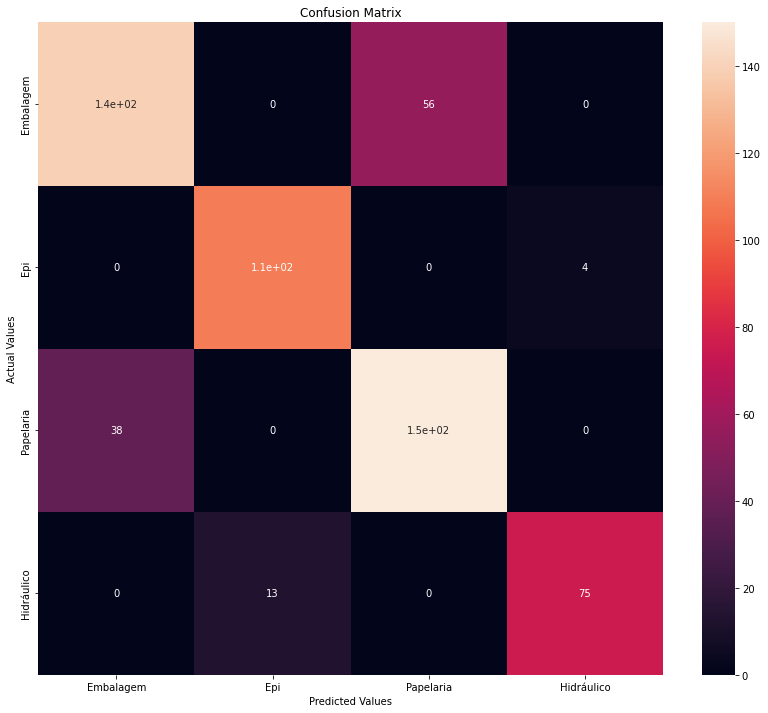

In [49]:
#Plotting the confusion matrix
plt.figure(figsize=(14,12))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

## Modelagem Castboost Classifier

In [50]:
%%time
# Modelo Base CatBoost Classifier
modelo_cat = CatBoostClassifier(iterations = 5000, eval_metric = 'MultiClass', metric_period = 50, learning_rate = 0.01, verbose = False)

CPU times: total: 0 ns
Wall time: 0 ns


In [51]:
modelo_cat.fit(X_train_tfidf, y_train)

In [52]:
y_train_pred, y_val_pred, y_test_pred = modelo_cat.predict(X_train_tfidf), modelo_cat.predict(X_val_tfidf), modelo_cat.predict(X_test_tfidf)
score_train, score_val, score_test = accuracy_score(y_train, y_train_pred), accuracy_score(y_val, y_val_pred), accuracy_score(y_test, y_test_pred)

In [53]:
print(f"Best validation accuracy: {score_test}")

Best validation accuracy: 0.7893835616438356


In [54]:
cm = confusion_matrix(y_test, y_test_pred)

In [55]:
cm

array([[154,   0,  41,   0],
       [  0, 112,   0,   1],
       [ 48,   0, 140,   0],
       [  0,  33,   0,  55]], dtype=int64)